In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from matplotlib import pyplot as plt

# Analyzing NOSC of the Cyanobacterial (PCC6803) proteome
We need in order to compare between experiments from different we need absolute quantification of proteins per unit volume. Recent datasets of this quality were collected for by Dan Davidi for Davidi et al. PNAS 2016. 

# Known issues
Using a reference genome for 6803 GT-S, but the data for GT-L. 

In [2]:
conds_df = pd.read_csv('../data/Zavrel_PCC6803_conditions.csv', dtype=dict(cond_id='str')).set_index('cond_id')
raw_abund_df = pd.read_csv('../data/Zavrel_PCC6803_proteome.csv')
nosc_df = pd.read_csv('../data/PCC6803_proteome_nosc.csv')

In [3]:
raw_abund_df['Gene names'].str.split(expand=True)

raw_abund_df['Gene names'].str.contains('slr0906')
notnull_mask = nosc_df.gene_id.notnull()
gids = []
idxs = []
for gid in nosc_df[notnull_mask].gene_id:
    mask = np.where(raw_abund_df['Gene names'].str.contains(gid))[0]
    if len(mask) == 1:
        idxs.append(mask[0])
        gids.append(gid)
    elif len(mask) > 1:
        print(gid, idxs)

print('found abundance data for', len(idxs), 'protein genes')
print('have abundance data for', raw_abund_df['Protein names'].size, 'protein genes')
print(nosc_df.gene_id.isnull().sum(), 'genes with null IDs')

found abundance data for 1431 protein genes
have abundance data for 1684 protein genes
6 genes with null IDs


In [4]:
my_nosc_df = nosc_df.set_index('gene_id')

data_cols = ['27.5', '55', '110', '220', '440', '1100']
# fg/mol = kg/mol * 1e18 fg/kg
mws_fg_mol = raw_abund_df.loc[idxs]['Mol. weight [kDa]'] * 1e18 
# copies/ul = 6.02e23 copies/mol * fg/ul / (fg/mol)
copies_per_ul = raw_abund_df[data_cols].loc[idxs].multiply(6.02e23/mws_fg_mol, axis=0)

Ce_total = copies_per_ul.multiply(my_nosc_df.loc[gids].Ce_tot.values, axis=0)
NC_total = copies_per_ul.multiply(my_nosc_df.loc[gids].NC.values, axis=0)
NOSC = Ce_total.sum()/NC_total.sum()
conds_df['NOSC'] = NOSC
conds_df

,red_light_intensity_uE_m_s,growth_rate_hr,spare_media_flow_rate_hr,dry_weight_mg_L,NOSC
cond_id,,,,,
27.5,27.5,0.025,0.028,132,-0.133554
55,55.0,0.039,0.034,166,-0.134911
110,110.0,0.059,0.048,173,-0.136333
220,220.0,0.081,0.070,220,-0.136950
440,440.0,0.104,0.121,221,-0.136758
660,660.0,0.104,0.118,260,NaN
880,880.0,0.990,0.089,256,NaN
1100,1100.0,0.930,0.086,231,-0.139903


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


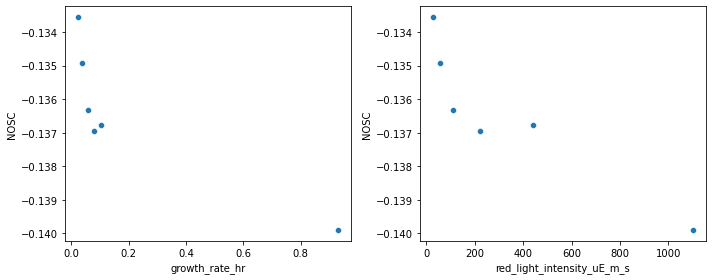

In [5]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

for ax, x_col in zip(axs, ['growth_rate_hr', 'red_light_intensity_uE_m_s']):
    plt.sca(ax)
    sns.scatterplot(data=conds_df, x=x_col, y='NOSC')
    plt.legend().set_visible(False)

plt.tight_layout()
plt.savefig('../output/protein_NOSC_Zavrel_data.png', facecolor='w', dpi=600)
plt.show()

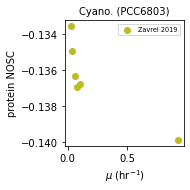

In [8]:
fig, ax = plt.subplots(figsize=(2.75,2.75), ncols=1)
plt.sca(ax)
pal = sns.color_palette()
plt.scatter(conds_df['growth_rate_hr'], conds_df['NOSC'], color=pal[-2], label='Zavrel 2019')

plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=10)
plt.ylabel('protein NOSC', fontsize=10)
plt.title('Cyano. (PCC6803)', fontsize=10)
plt.legend(loc=1, fontsize=6.5)

plt.tight_layout()
plt.savefig('../output/PCC6301_proteomics_NOSC.png', facecolor='w', dpi=600)
plt.show()